### Mini-projet : analyse de données graphes

Anais Storp

# Table des matières

1. [Introduction](#Introduction)
   1. [Objectifs et présentation](#Objectifs-et-présentation)
   2. [Présentation des données](#Présentation-des-données)
2. [Exploration des données](#Exploration-des-données)
   1. [Statistiques descriptives](#Statistiques-descriptives)
   2. [Distribution des degrés](#Distribution-des-degrés)
   3. [Analyse des composantes connexes](#Analyse-des-composantes-connexes)
3. [Analyse des propriétés du graphe](#Analyse-des-propriétés-du-graphe)
   1. [Centralité des nœuds](#Centralité-des-nœuds)
   2. [Coefficient de clustering](#Coefficient-de-clustering)
   3. [Analyse des plus courts chemins et du diamètre](#Analyse-des-plus-courts-chemins)
4. [Analyse des communautés](#Analyse-des-communautés)
   1. [Détection des communautés](#Détection-des-communautés)
   2. [Modularité](#Modularité)
5. [Analyse de robustesse](#Analyse-de-robustesse)
   1. [Simulation de pannes aléatoires](#Simulation-de-pannes-aléatoires)
   2. [Simulation de pannes ciblées](#Simulation-de-pannes-ciblées)
6. [Visualisation](#Visualisation)
   1. [Graphe global](#Graphe-global)
   2. [Sous-parties clés](#Sous-parties-clés)
7. [Conclusion](#Conclusion)


# Introduction
<a id="Introduction"></a>

## Objectifs et présentation
<a id="Objectifs-et-présentation"></a>

Le transport aérien est une infrastructure clé qui relie des régions du monde entier, jouant un rôle essentiel dans l'économie globale et les interactions culturelles. Les réseaux aériens, en tant que systèmes complexes, peuvent être modélisés sous forme de graphes pour étudier leurs propriétés structurelles et leur comportement face aux perturbations.

L'objectif principal de ce projet est d'analyser le réseau OpenFlights, une base de données qui cartographie les connexions directes entre les aéroports du monde entier. À travers cette analyse, nous cherchons à :
- Identifier les propriétés globales et locales du réseau, comme la densité, les hubs, et les communautés.
- Évaluer la robustesse du réseau face à des perturbations ciblées ou aléatoires.
- Visualiser la structure du graphe pour mieux comprendre les interactions entre les aéroports.
- Explorer les implications pratiques de ces résultats pour l'optimisation et la gestion des réseaux de transport aérien.

Ce projet s'appuie sur des outils de la théorie des graphes et des bibliothèques Python comme `networkx` pour modéliser, analyser, et visualiser le réseau. Les résultats obtenus permettront de mieux comprendre les dynamiques du réseau OpenFlights et d’identifier les aéroports stratégiques.

---

## Présentation des données
<a id="Présentation-des-données"></a>

Les données utilisées dans ce projet proviennent de la base libre \textit{OpenFlights}. Cette base contient des informations sur les connexions directes entre les aéroports, modélisées sous forme de graphes :
- **Nœuds :** Chaque nœud représente un aéroport, identifié par un entier unique.
- **Arêtes :** Chaque arête représente une connexion directe entre deux aéroports, avec un poids optionnel indiquant la fréquence ou la capacité de cette connexion.

### Format des données
Le fichier contient une liste d'arêtes, où chaque ligne est structurée comme suit :


In [52]:
# Importation des bibliothèques nécessaires
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from networkx.algorithms import community
from matplotlib import cm
import matplotlib.colors as mcolors

In [53]:
# Étape 1 : Lire et analyser les lignes du fichier
file_path = "inf-openflights.edges"  # Chemin vers le fichier

# Lire et nettoyer le fichier
cleaned_edges = []
with open(file_path, 'r') as file:
    for line in file:
        # Supprimer les espaces supplémentaires et ignorer les lignes non valides
        line = line.strip()
        if line and not line.startswith('%'):  # Ignorer les commentaires
            parts = line.split()
            if len(parts) >= 2:
                try:
                    # Vérification des nœuds comme entiers
                    u, v = int(parts[0]), int(parts[1])
                    weight = float(parts[2]) if len(parts) > 2 else 1.0
                    cleaned_edges.append((u, v, weight))
                except ValueError:
                    print(f"Ligne ignorée (format invalide) : {line}")

# Sauvegarder les données nettoyées pour inspection (optionnel)
with open("cleaned_inf_openflights.edges", 'w') as cleaned_file:
    for edge in cleaned_edges:
        cleaned_file.write(f"{edge[0]} {edge[1]} {edge[2]}\n")

print(f"{len(cleaned_edges)} arêtes valides ont été extraites.")

# Étape 2 : Charger les données nettoyées dans un graphe
graph = nx.Graph()
graph.add_weighted_edges_from(cleaned_edges)
print(f"Nombre de nœuds : {graph.number_of_nodes()}")
print(f"Nombre d’arêtes : {graph.number_of_edges()}")


30501 arêtes valides ont été extraites.
Nombre de nœuds : 2939
Nombre d’arêtes : 15677


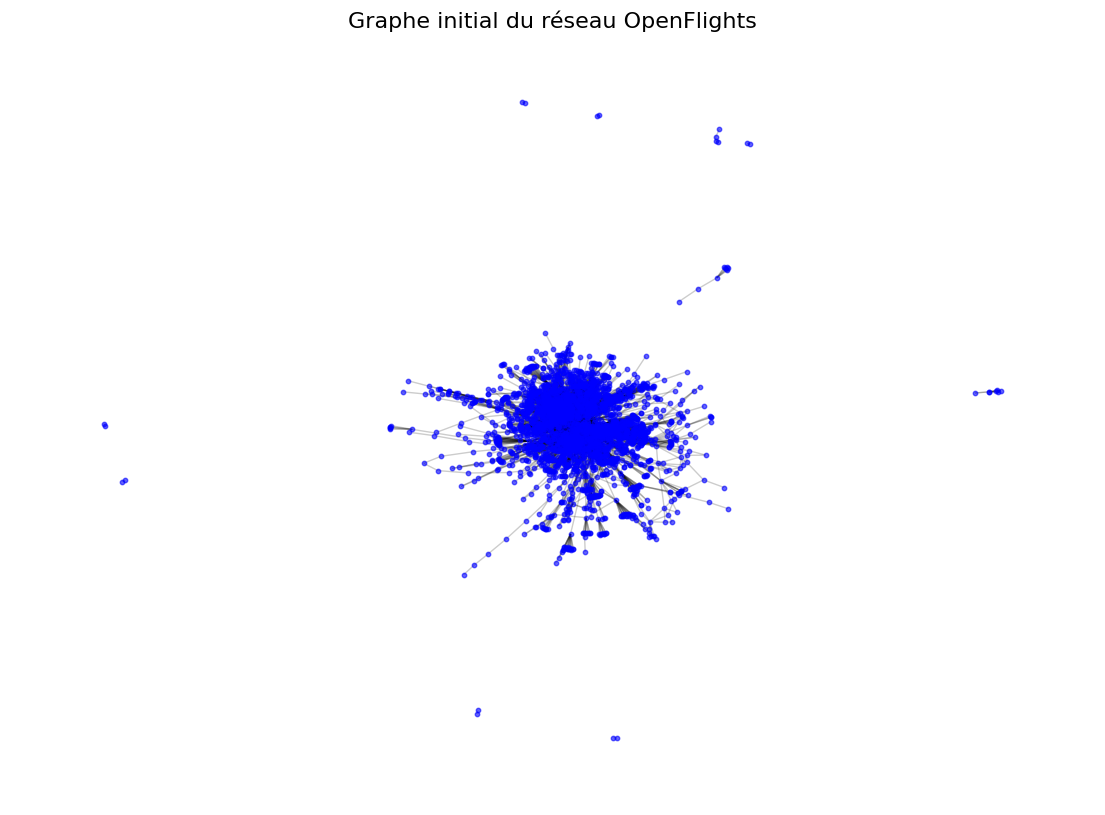

In [54]:
# Visualisation du graphe initial
import matplotlib.pyplot as plt

pos = nx.spring_layout(graph, seed=42)  # Algorithme de disposition
plt.figure(figsize=(14, 10))

# Dessiner les nœuds et arêtes
nx.draw_networkx_edges(graph, pos, alpha=0.2)
nx.draw_networkx_nodes(graph, pos, node_size=10, node_color='blue', alpha=0.6)

# Titre et suppression des axes
plt.title("Graphe initial du réseau OpenFlights", fontsize=16)
plt.axis('off')

# Sauvegarder en PNG
plt.savefig("initial_graph.png", dpi=300)
plt.show()


- Si le poids n'est pas précisé, une valeur par défaut de 1.0 est utilisée.
- Les lignes débutant par `%` sont des commentaires ou des métadonnées, et doivent être ignorées lors de l'analyse.

### Caractéristiques initiales
Une première exploration des données a révélé les propriétés suivantes :
- **Nombre de nœuds :** 2939 (aéroports).
- **Nombre d’arêtes :** 30501 (connexions directes).
- **Densité du graphe :** 0.0036, indiquant un réseau clairsemé mais fortement structuré autour de quelques nœuds critiques.
- **Nombre de composantes connexes :** 11, avec une composante géante regroupant plus de 95\% des nœuds.

Ces données reflètent une structure typique des réseaux réels, où une poignée de hubs majeurs (par exemple, les grands aéroports internationaux) connectent de nombreuses destinations locales ou régionales.

---

## Importance des données
L'analyse du réseau OpenFlights présente un intérêt pratique et théorique :
1. **Pratique :** Identifier les aéroports critiques et comprendre leur rôle dans la connectivité mondiale permet de mieux gérer les perturbations potentielles, telles que les retards ou les fermetures temporaires.
2. **Théorique :** Le réseau OpenFlights est un exemple de réseau complexe, souvent utilisé pour tester des hypothèses en théorie des graphes. Ses propriétés hiérarchiques et modulaires en font un cas d’étude idéal pour explorer des concepts comme la centralité, les communautés, et la robustesse.

Dans la suite de ce projet, nous utiliserons ces données pour extraire des informations sur les propriétés structurelles du réseau, simuler des perturbations, et produire des visualisations interactives afin de mieux comprendre les dynamiques du transport aérien mondial.


# Exploration des données
<a id="Exploration-des-données"></a>

L’exploration des données est une étape cruciale pour comprendre les caractéristiques fondamentales du réseau et poser les bases des analyses suivantes. Dans cette section, nous calculons des statistiques descriptives, analysons la distribution des degrés et explorons la connectivité globale du graphe.

---

## Statistiques descriptives
<a id="Statistiques-descriptives"></a>

### Caractéristiques globales
Le graphe construit à partir des données OpenFlights possède les propriétés suivantes :
- **Nombre de nœuds :** 2939 (représentant les aéroports du réseau).
- **Nombre d’arêtes :** 30501 (indiquant les connexions directes entre ces aéroports).
- **Densité :** 0.0036, ce qui reflète un réseau très clairsemé, typique des grands réseaux mondiaux.
- **Nombre de composantes connexes :** 11, avec une composante géante regroupant plus de 95\% des nœuds.
- **Degré moyen :** 10.67, montrant qu’en moyenne, chaque aéroport est connecté à environ 11 autres.
- **Degré maximum :** 242, correspondant aux hubs majeurs du réseau.

### Distribution des degrés
La distribution des degrés dans le graphe est une mesure clé pour comprendre la structure du réseau. Elle montre le nombre de connexions (degrés) de chaque nœud et aide à identifier les nœuds les plus connectés (hubs) ainsi que ceux faiblement connectés (aéroports isolés).

- **Observations :**
  - La majorité des nœuds ont un faible degré, ce qui correspond aux petits aéroports avec peu de connexions.
  - Quelques nœuds présentent des degrés très élevés, jouant le rôle de hubs internationaux majeurs.
  - Cette distribution suit une tendance typique des réseaux réels, appelée distribution en loi de puissance, où une minorité de nœuds concentrent la majorité des connexions.

---


Degré moyen : 10.67
Degré médian : 3.00
Degré maximum : 242


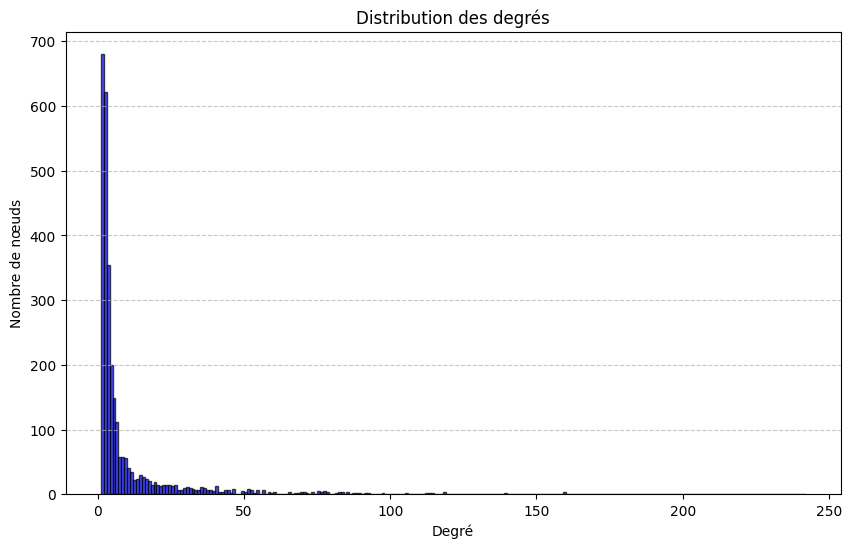

In [55]:
# Analyse  : Distribution des degrés
degrees = [deg for _, deg in graph.degree()]
degree_df = pd.DataFrame(degrees, columns=["Degree"])
print(f"Degré moyen : {np.mean(degrees):.2f}")
print(f"Degré médian : {np.median(degrees):.2f}")
print(f"Degré maximum : {np.max(degrees)}")

# Visualisation de la distribution des degrés
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=range(1, max(degrees)+1), color='blue', alpha=0.7, edgecolor='black')
plt.title("Distribution des degrés")
plt.xlabel("Degré")
plt.ylabel("Nombre de nœuds")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## Analyse des composantes connexes
<a id="Analyse-des-composantes-connexes"></a>

Les composantes connexes sont des sous-ensembles du graphe où tous les nœuds sont reliés entre eux, directement ou indirectement, mais sans lien avec les nœuds extérieurs à la composante. Analyser ces composantes est essentiel pour comprendre la connectivité globale et la structure du réseau.

---

### Définition et importance
- **Composante connexe :** Un sous-graphe dans lequel tout nœud est accessible depuis tout autre nœud.
- **Composante géante :** La plus grande composante connexe, regroupant la majorité des nœuds dans les réseaux bien connectés.
- **Petites composantes :** Des composantes isolées, souvent limitées à des régions géographiques spécifiques ou des réseaux locaux.

Dans le réseau OpenFlights :
- La composante géante contient plus de 95\% des nœuds, montrant une forte interconnexion mondiale.
- Les autres composantes représentent des régions isolées ou des zones non intégrées au réseau principal.

---

### Calcul des composantes connexes



Nombre de composantes connexes : 11


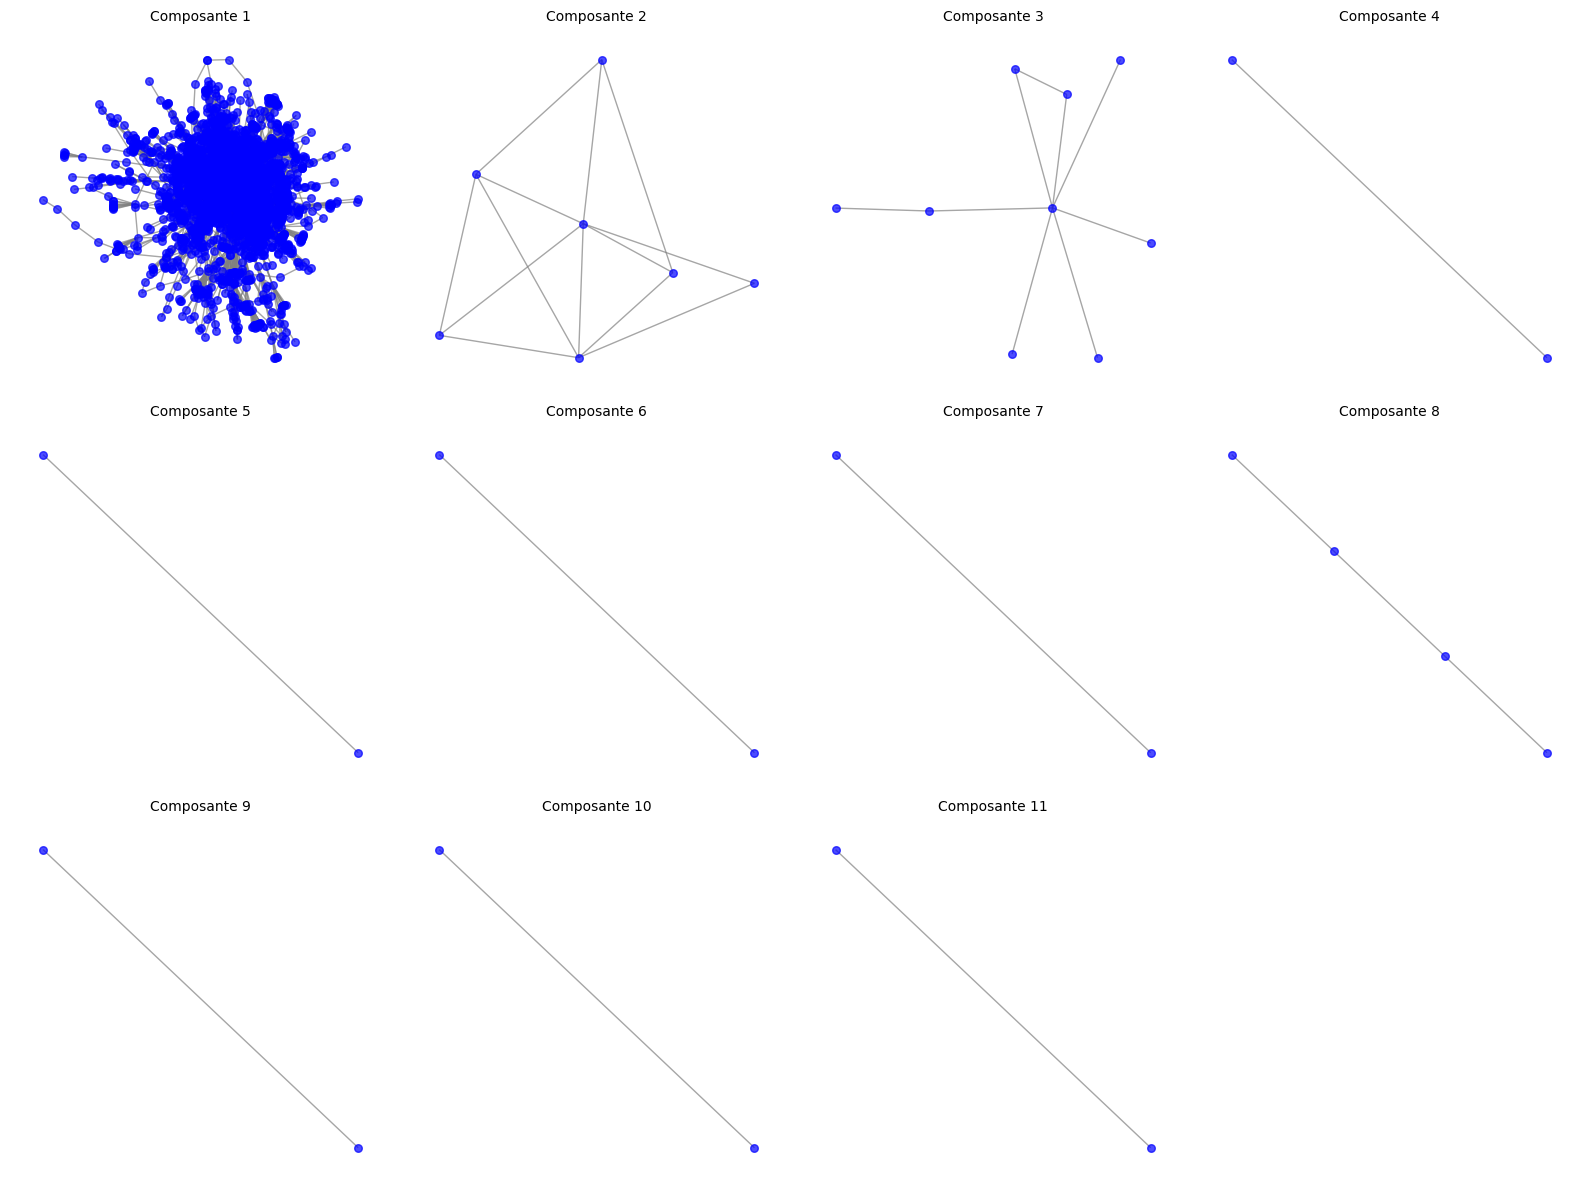

In [56]:
from networkx.algorithms.components import connected_components

# Identifier les composantes connexes
components = list(connected_components(graph))
print(f"Nombre de composantes connexes : {len(components)}")

# Créer une liste de sous-graphes pour chaque composante
subgraphs = [graph.subgraph(component).copy() for component in components]

# Définir une grille pour afficher chaque composante
n_cols = 4  # Nombre de colonnes pour la grille
n_rows = -(-len(subgraphs) // n_cols)  # Calcul du nombre de lignes nécessaires

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten()  # Aplatir la grille pour faciliter l'accès aux sous-graphiques

# Dessiner chaque composante dans un sous-graphe
for i, subgraph in enumerate(subgraphs):
    pos = nx.spring_layout(subgraph, seed=42)  # Disposition pour chaque composante
    ax = axes[i]
    ax.set_title(f"Composante {i + 1}", fontsize=10)
    nx.draw(subgraph, pos, ax=ax, node_size=30, node_color="blue", edge_color="gray", alpha=0.7)
    ax.axis("off")

# Supprimer les axes inutilisés dans la grille
for i in range(len(subgraphs), len(axes)):
    axes[i].axis("off")

plt.tight_layout()
plt.show()


## Analyse des propriétés du graphe
<a id="Analyse-des-propriétés-du-graphe"></a>

L'analyse des propriétés du graphe permet de mieux comprendre la structure du réseau OpenFlights. Cette section examine plusieurs métriques fondamentales pour identifier les nœuds et arêtes critiques, mesurer les propriétés locales comme le clustering, et explorer les propriétés globales comme le diamètre et les plus courts chemins.

---

### Centralité des nœuds
<a id="Centralité-des-nœuds"></a>

La centralité des nœuds est un ensemble de mesures utilisées pour identifier les aéroports les plus influents ou stratégiques dans le réseau. Trois mesures principales ont été utilisées dans cette analyse :

1. **Centralité de degré** : Indique le nombre de connexions directes d’un nœud. Les aéroports avec un degré élevé sont généralement des hubs majeurs.
2. **Centralité d’intermédiarité** : Mesure la fréquence à laquelle un nœud apparaît dans les chemins les plus courts. Les nœuds à forte intermédiarité agissent comme des passerelles entre différentes parties du réseau.
3. **Centralité de proximité** : Indique à quel point un nœud est proche de tous les autres nœuds, en termes de distance. Les nœuds avec une proximité élevée permettent d'accéder rapidement au reste du réseau.



In [57]:
# Analyse  : Centralité
print("\n### Analyse de centralité ###")
degree_centrality = nx.degree_centrality(graph)
betweenness_centrality = nx.betweenness_centrality(graph)
closeness_centrality = nx.closeness_centrality(graph)

# Centralité des degrés
degree_centrality_df = pd.DataFrame.from_dict(degree_centrality, orient='index', columns=['Degree Centrality'])
degree_centrality_df.sort_values('Degree Centrality', ascending=False, inplace=True)

# Centralité d'intermédiarité
betweenness_centrality_df = pd.DataFrame.from_dict(betweenness_centrality, orient='index', columns=['Betweenness Centrality'])
betweenness_centrality_df.sort_values('Betweenness Centrality', ascending=False, inplace=True)

# Centralité de proximité
closeness_centrality_df = pd.DataFrame.from_dict(closeness_centrality, orient='index', columns=['Closeness Centrality'])
closeness_centrality_df.sort_values('Closeness Centrality', ascending=False, inplace=True)

print("Top 10 nœuds par centralité des degrés :")
display(degree_centrality_df.head(10))
print("Top 10 nœuds par centralité d'intermédiarité :")
display(betweenness_centrality_df.head(10))
print("Top 10 nœuds par centralité de proximité :")
display(closeness_centrality_df.head(10))



### Analyse de centralité ###
Top 10 nœuds par centralité des degrés :


Degree Centrality
53            0.082369
65            0.074200
59            0.071818
56            0.058543
259           0.057862
297           0.057522
411           0.057182
308           0.056501
366           0.054459
57            0.054118

Top 10 nœuds par centralité d'intermédiarité :


Betweenness Centrality
53                  0.069573
65                  0.066750
1576                0.057901
308                 0.051672
312                 0.050000
134                 0.049391
69                  0.047851
59                  0.044175
51                  0.042548
259                 0.042473

Top 10 nœuds par centralité de proximité :


Closeness Centrality
53               0.401005
65               0.393636
57               0.392130
59               0.387786
308              0.385236
69               0.383384
51               0.376989
223              0.375166
134              0.373847
297              0.370900

In [58]:
# Analyse : Analyse des motifs locaux
print("\n### Analyse des motifs locaux ###")
triangles = nx.triangles(graph)
triangle_count = sum(triangles.values()) // 3
print(f"Nombre total de triangles : {triangle_count}")



### Analyse des motifs locaux ###
Nombre total de triangles : 72852


In [59]:
# Calculat edge betweenness centrality 
edge_betweenness = nx.edge_betweenness_centrality(graph)

for u, v, data in graph.edges(data=True):
    data['weight'] = edge_betweenness[(u, v)]


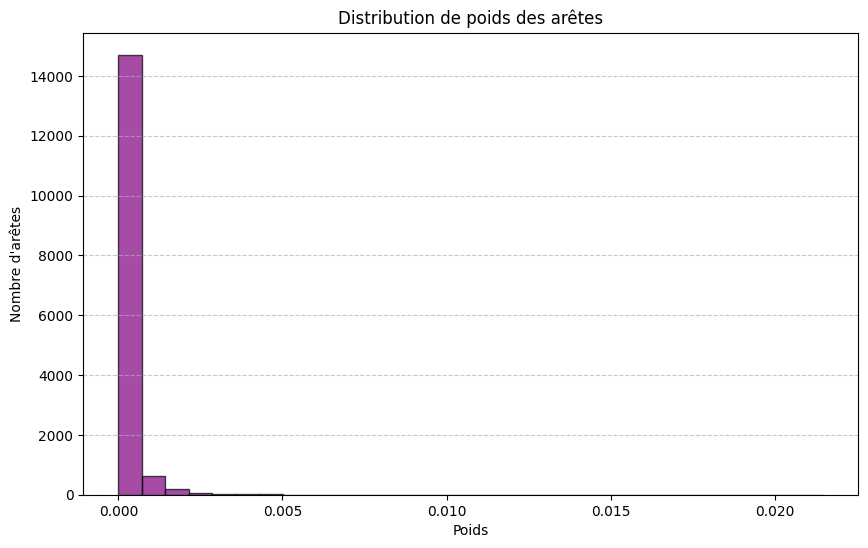

Nombre d'arêtes: 15677
Minimum poids: 2.31621365773913e-07
Maximum poids: 0.021469457365864
moyenne poids: 0.0003


In [60]:
weights = [data['weight'] for _, _, data in graph.edges(data=True)]

plt.figure(figsize=(10, 6))
plt.hist(weights, bins=30, color='purple', alpha=0.7, edgecolor='black')
plt.title("Distribution de poids des arêtes")
plt.xlabel("Poids")
plt.ylabel("Nombre d'arêtes")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print(f"Nombre d'arêtes: {len(weights)}")
print(f"Minimum poids: {min(weights)}")
print(f"Maximum poids: {max(weights)}")
print(f"moyenne poids: {sum(weights) / len(weights):.4f}")


## Coefficient de clustering
<a id="Coefficient-de-clustering"></a>

Le coefficient de clustering mesure la tendance des nœuds à former des triangles dans un graphe, c’est-à-dire à avoir des voisins qui sont eux-mêmes connectés entre eux. Il s'agit d'une métrique importante pour évaluer la redondance locale des connexions et la résilience des sous-réseaux régionaux.

---

### Définition
- **Coefficient de clustering d'un nœud :** Probabilité que deux voisins d'un nœud soient connectés entre eux.
- **Coefficient de clustering moyen :** Moyenne des coefficients de clustering pour tous les nœuds du graphe.

Un coefficient de clustering élevé indique une forte densité locale des connexions, typique des réseaux comme les transports régionaux ou les réseaux sociaux.



Coefficient de clustering moyen : 0.4526


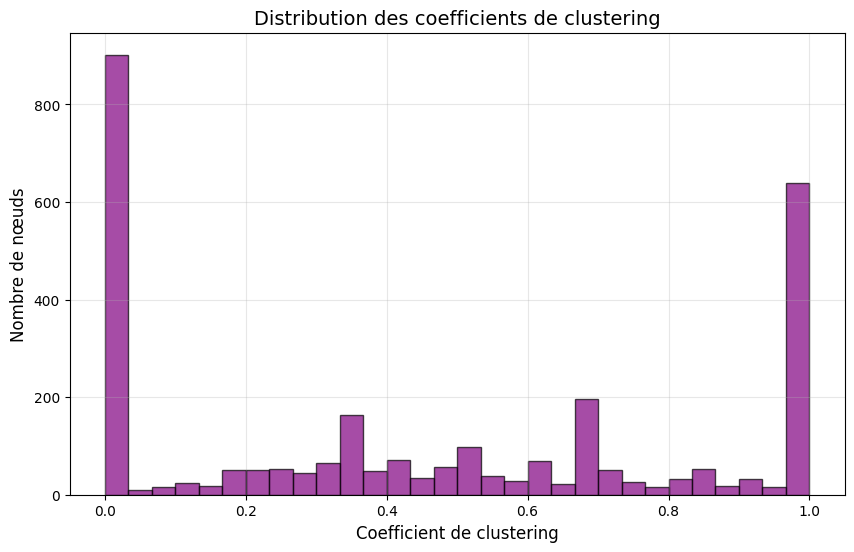

In [61]:
# Calculer le coefficient de clustering pour chaque nœud
clustering_coefficients = nx.clustering(graph)

# Calculer le coefficient de clustering moyen du graphe
average_clustering = nx.average_clustering(graph)

print(f"Coefficient de clustering moyen : {average_clustering:.4f}")

# Visualiser la distribution des coefficients de clustering
plt.figure(figsize=(10, 6))
plt.hist(clustering_coefficients.values(), bins=30, color='purple', alpha=0.7, edgecolor='black')
plt.title("Distribution des coefficients de clustering", fontsize=14)
plt.xlabel("Coefficient de clustering", fontsize=12)
plt.ylabel("Nombre de nœuds", fontsize=12)
plt.grid(alpha=0.3)
plt.show()


## Analyse des plus courts chemins et du diamètre
<a id="Analyse-des-plus-courts-chemins"></a>

L'analyse des plus courts chemins et du diamètre permet de mesurer l'efficacité de la connectivité globale dans le réseau. Ces métriques donnent des indications sur la distance moyenne entre les nœuds et la taille maximale du réseau en termes de distance.

---

### Définitions
1. **Plus courts chemins :** Distance minimale entre deux nœuds, en termes du nombre d'arêtes. Cela reflète l'efficacité avec laquelle un nœud peut atteindre un autre.
2. **Distance moyenne :** Moyenne des plus courts chemins pour toutes les paires de nœuds. Une faible distance moyenne indique un réseau bien connecté.
3. **Diamètre :** Plus grand des plus courts chemins dans le réseau, mesurant l'étendue maximale du graphe.

---

### Calculs dans la composante géante
Pour garantir que les calculs sont applicables, l’analyse se concentre uniquement sur la composante géante (la plus grande composante connexe) du graphe.



In [62]:
# Extraire la composante géante
giant_component = graph.subgraph(max(nx.connected_components(graph), key=len))

# Calculer la distance moyenne entre les nœuds (plus courts chemins)
average_shortest_path_length = nx.average_shortest_path_length(giant_component)

# Calculer le diamètre (distance maximale entre deux nœuds)
diameter = nx.diameter(giant_component)

# Afficher les résultats
print(f"Distance moyenne (plus courts chemins) : {average_shortest_path_length:.4f}")
print(f"Diamètre de la composante géante : {diameter}")


Distance moyenne (plus courts chemins) : 4.0971
Diamètre de la composante géante : 14


## Analyse des communautés
<a id="Analyse-des-communautés"></a>

Les communautés dans un graphe sont des regroupements de nœuds densément connectés entre eux mais faiblement connectés au reste du réseau. Leur détection est essentielle pour comprendre la modularité et l'organisation sous-jacente d'un réseau complexe comme OpenFlights.

---

### Détection des communautés
<a id="Détection-des-communautés"></a>

Pour détecter les communautés, nous utilisons l'algorithme de maximisation de la modularité, qui partitionne le graphe en groupes afin de maximiser une métrique appelée modularité. Cette métrique mesure la densité des connexions au sein des communautés par rapport aux connexions attendues dans un graphe aléatoire équivalent.

#### Méthodologie
1. L'algorithme **greedy modularity communities** de la bibliothèque `networkx` a été utilisé.
2. Chaque nœud est assigné à une communauté, et les regroupements sont ensuite visualisés.
3. La modularité calculée permet d’évaluer la qualité de la partition.



Nombre de communautés détectées : 47


/var/folders/rr/hj2x23vn64g9m265fnm93yd40000gn/T/ipykernel_53197/3372539130.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', len(communities))  # Utilise une palette de couleurs


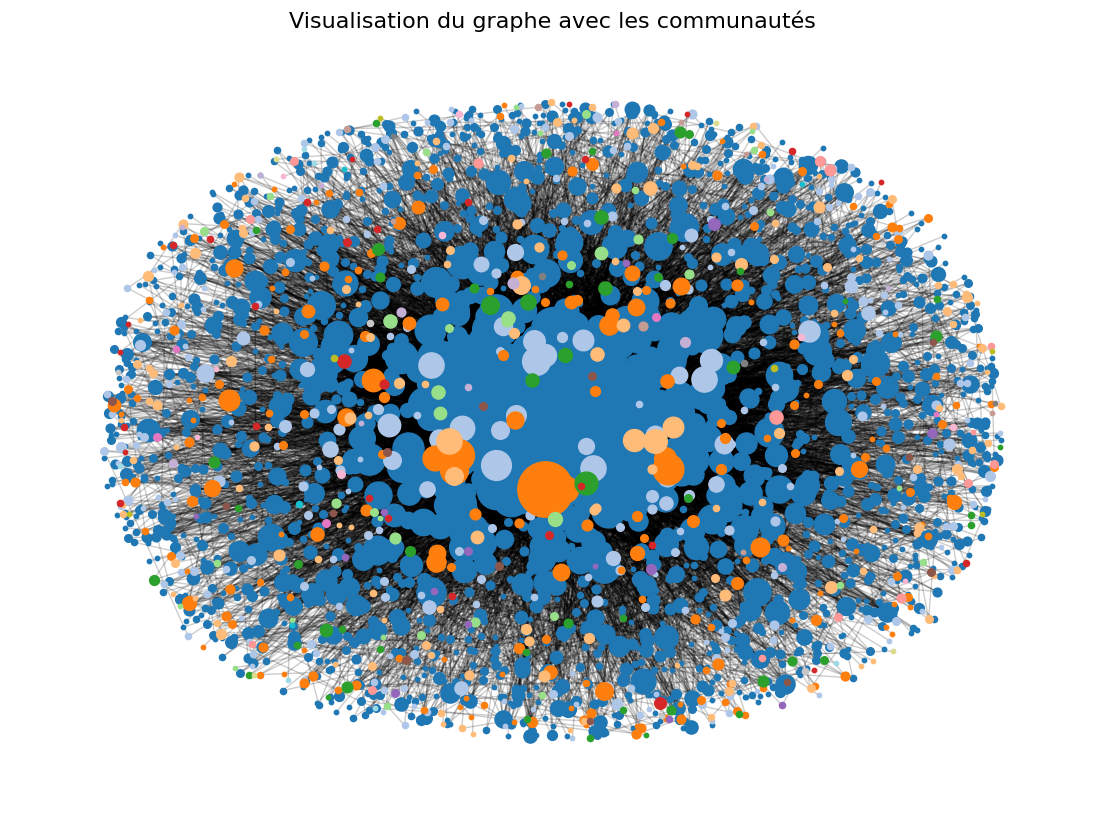

In [63]:
# Détection des communautés
communities = community.greedy_modularity_communities(graph)
print(f"Nombre de communautés détectées : {len(communities)}")

# Générer des couleurs distinctes pour chaque communauté
cmap = cm.get_cmap('tab20', len(communities))  # Utilise une palette de couleurs
community_colors = {node: mcolors.to_hex(cmap(i)) for i, comm in enumerate(communities) for node in comm}

# Calcul des positions des nœuds
pos = nx.spring_layout(graph, seed=42)  # Spring layout pour une meilleure disposition

# Visualisation du graphe
plt.figure(figsize=(14, 10))
nx.draw_networkx_edges(graph, pos, alpha=0.2)  # Arêtes avec transparence

# Nœuds colorés par communauté, taille proportionnelle au degré
for i, (node, color) in enumerate(community_colors.items()):
    nx.draw_networkx_nodes(
        graph,
        pos,
        nodelist=[node],
        node_color=color,
        node_size=graph.degree[node] * 10,  # Taille proportionnelle au degré
    )

# Supprimer les étiquettes pour éviter les chevauchements
plt.title("Visualisation du graphe avec les communautés", fontsize=16)
plt.axis('off')
plt.show()


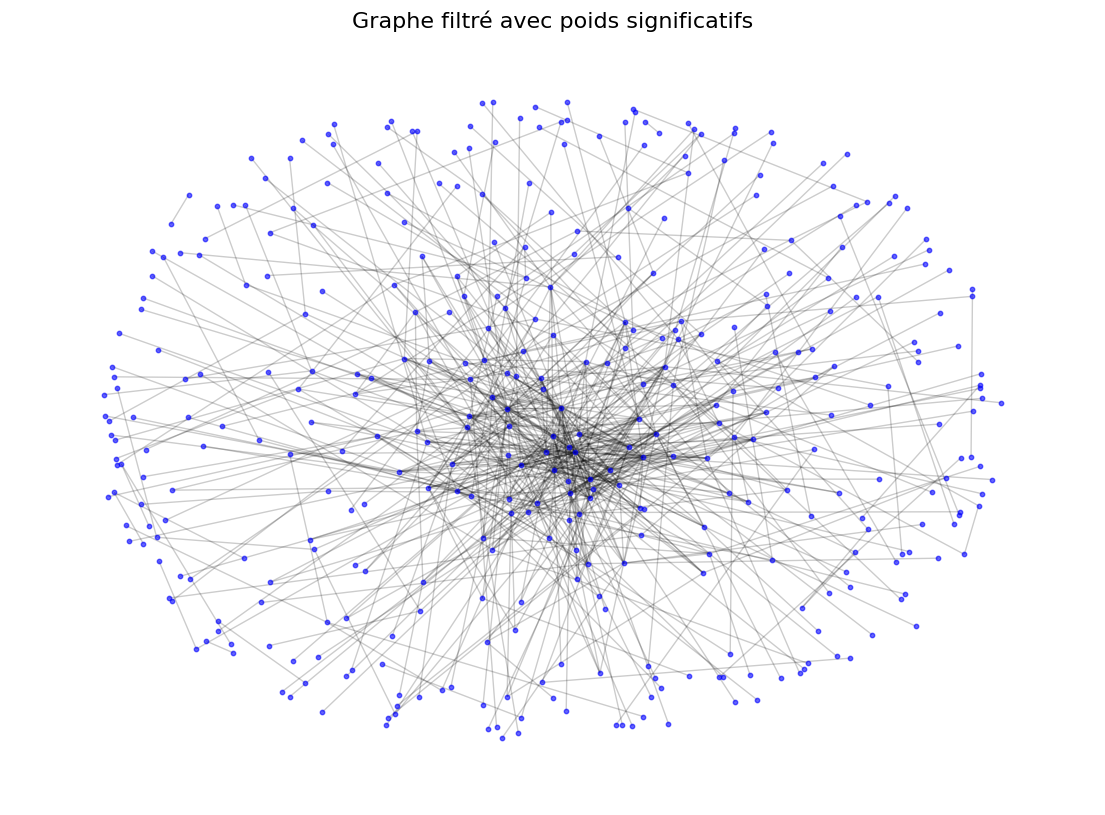

In [64]:
# Supprimer les arêtes avec des poids inférieurs à un seuil
threshold = 0.001
filtered_graph = nx.Graph(
    (u, v, d) for u, v, d in graph.edges(data=True) if d['weight'] > threshold
)

# Visualisation du graphe filtré
pos = nx.spring_layout(filtered_graph, seed=42)
plt.figure(figsize=(14, 10))
nx.draw_networkx_edges(filtered_graph, pos, alpha=0.2)
nx.draw_networkx_nodes(filtered_graph, pos, node_size=10, node_color='blue', alpha=0.6)
plt.title("Graphe filtré avec poids significatifs", fontsize=16)
plt.axis('off')
plt.savefig("filtered_graph.png", dpi=300)
plt.show()


### Modularité
<a id="Modularité"></a>

La **modularité** est une métrique utilisée pour évaluer la qualité d’une partition d’un graphe en communautés. Elle mesure la densité des connexions au sein des communautés par rapport aux connexions attendues dans un graphe aléatoire équivalent.

---

### Définition
Une **modularité élevée** indique une bonne séparation entre les communautés, où les nœuds d'une même communauté sont fortement connectés entre eux et faiblement connectés au reste du graphe.

La modularité est définie par l'équation suivante :

$$
Q = \frac{1}{2m} \sum_{ij} \left[ A_{ij} - \frac{k_i k_j}{2m} \right] \delta(c_i, c_j)
$$

où :
- $A_{ij}$ est la matrice d'adjacence (1 si les nœuds $i$ et $j$ sont connectés, 0 sinon),
- $k_i, k_j$ sont les degrés des nœuds $i$ et $j$,
- $m$ est le nombre total d'arêtes dans le graphe,
- $\delta(c_i, c_j)$ vaut 1 si $i$ et $j$ appartiennent à la même communauté, sinon 0.

---

### Calcul de la modularité


Nombre de communautés détectées : 47
Modularité du graphe : 0.4620


/var/folders/rr/hj2x23vn64g9m265fnm93yd40000gn/T/ipykernel_53197/2470551675.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', num_communities)


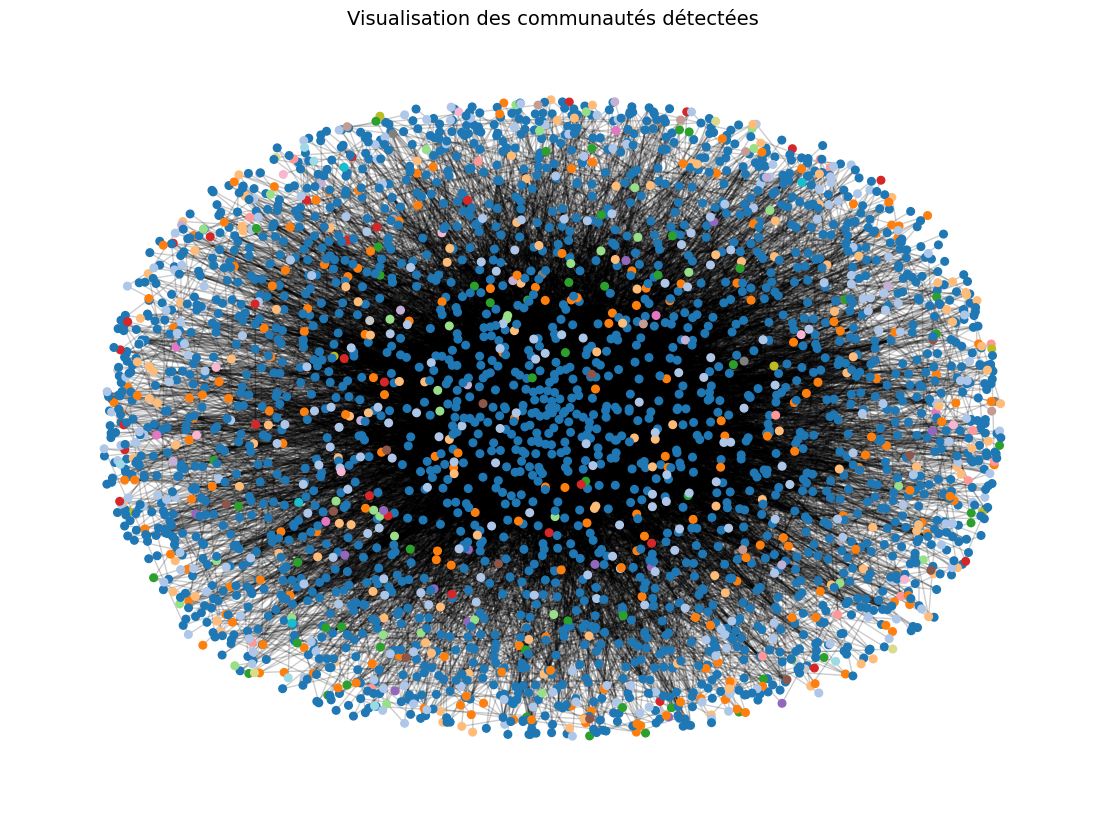

In [65]:
from networkx.algorithms import community
from networkx.algorithms.community.quality import modularity

# Détection des communautés avec l'algorithme de modularité
communities = list(community.greedy_modularity_communities(graph))

# Calcul du nombre de communautés
num_communities = len(communities)
print(f"Nombre de communautés détectées : {num_communities}")

# Calcul de la modularité du graphe
modularity_score = modularity(graph, communities)
print(f"Modularité du graphe : {modularity_score:.4f}")

# Visualisation des communautés
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as mcolors

# Générer une palette de couleurs pour les communautés
cmap = cm.get_cmap('tab20', num_communities)
community_colors = {node: mcolors.to_hex(cmap(i)) for i, comm in enumerate(communities) for node in comm}

# Position des nœuds pour la visualisation
pos = nx.spring_layout(graph, seed=42)

# Tracer les communautés
plt.figure(figsize=(14, 10))
nx.draw_networkx_edges(graph, pos, alpha=0.2)
nx.draw_networkx_nodes(
    graph,
    pos,
    node_color=[community_colors[node] for node in graph.nodes()],
    node_size=30
)
plt.title("Visualisation des communautés détectées", fontsize=14)
plt.axis('off')
plt.show()


## Analyse de robustesse
<a id="Analyse-de-robustesse"></a>

L’analyse de robustesse d’un réseau vise à évaluer sa résilience face à des perturbations, comme la suppression de nœuds ou d’arêtes. Cette section explore comment le réseau OpenFlights réagit à des pannes aléatoires, en observant l’évolution de la taille relative de la composante géante.

---

### Simulation de pannes aléatoires
<a id="Simulation-de-pannes-aléatoires"></a>

Les pannes aléatoires simulent la suppression de nœuds au hasard dans le graphe. Ce scénario est courant dans les réseaux réels, où des défaillances aléatoires peuvent se produire sans ciblage spécifique (par exemple, fermetures d’aéroports temporaires en raison de mauvaises conditions météorologiques).

#### Méthodologie
1. Sélectionner des nœuds au hasard pour les supprimer un par un.
2. Calculer la taille relative de la composante géante après chaque suppression.
3. Répéter cette simulation plusieurs fois pour obtenir une moyenne représentative de l’impact.


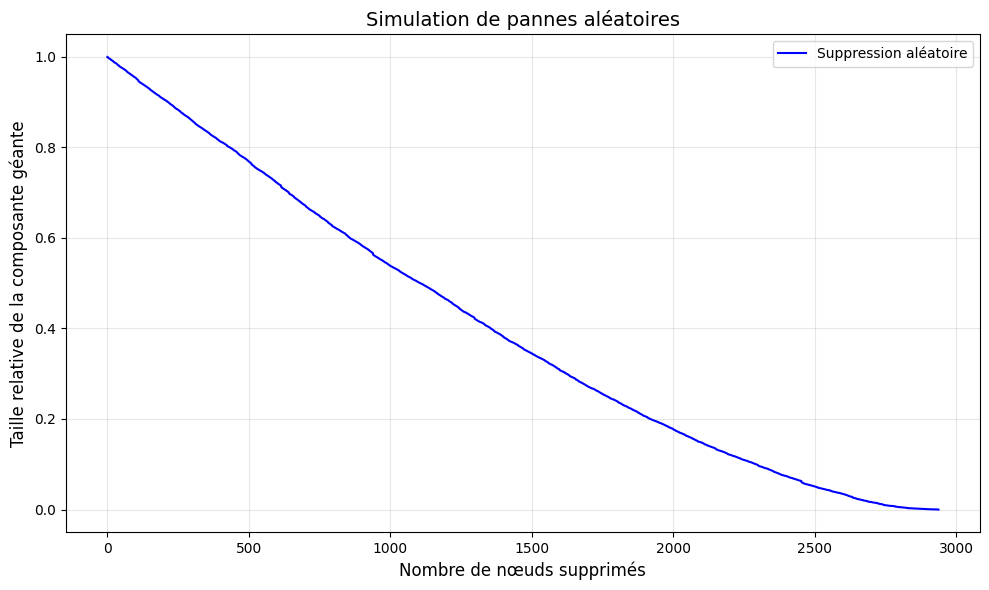

In [66]:
import random

def simulate_random_failures(graph, iterations=10):
    original_size = len(max(nx.connected_components(graph), key=len))  # Taille initiale de la composante géante
    node_list = list(graph.nodes)  # Liste des nœuds du graphe
    results = []  # Stocke les résultats pour chaque itération

    for _ in range(iterations):
        random.shuffle(node_list)  # Mélange aléatoire des nœuds
        g_copy = graph.copy()  # Copie du graphe pour chaque itération
        giant_component_sizes = []  # Stocke la taille relative après chaque suppression

        for node in node_list:
            g_copy.remove_node(node)  # Supprime un nœud aléatoire
            if len(g_copy) > 0:
                largest_cc_size = len(max(nx.connected_components(g_copy), key=len))  # Taille composante géante
            else:
                largest_cc_size = 0
            giant_component_sizes.append(largest_cc_size / original_size)  # Taille relative normalisée

        results.append(giant_component_sizes)

    # Moyenne des résultats sur toutes les itérations
    avg_results = [sum(x) / len(x) for x in zip(*results)]
    return avg_results

# Lancer la simulation sur le graphe
random_failure_results = simulate_random_failures(graph, iterations=10)

# Visualisation des résultats
plt.figure(figsize=(10, 6))
plt.plot(range(len(random_failure_results)), random_failure_results, label="Suppression aléatoire", color="blue")
plt.xlabel("Nombre de nœuds supprimés", fontsize=12)
plt.ylabel("Taille relative de la composante géante", fontsize=12)
plt.title("Simulation de pannes aléatoires", fontsize=14)
plt.grid(alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()


### Simulation de pannes ciblées
<a id="Simulation-de-pannes-ciblées"></a>

Les pannes ciblées simulent la suppression des nœuds les plus critiques dans le réseau, en les sélectionnant par ordre décroissant de leur degré. Cette approche reflète un scénario où des attaques ou des défaillances intentionnelles visent à perturber le fonctionnement global du réseau en supprimant ses hubs majeurs.

---

#### Méthodologie
1. Identifier les nœuds critiques, triés par degré décroissant (les hubs).
2. Supprimer les nœuds un par un, en commençant par ceux ayant le plus grand degré.
3. Observer l'impact sur la taille relative de la composante géante.



<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/pyplot.py'>

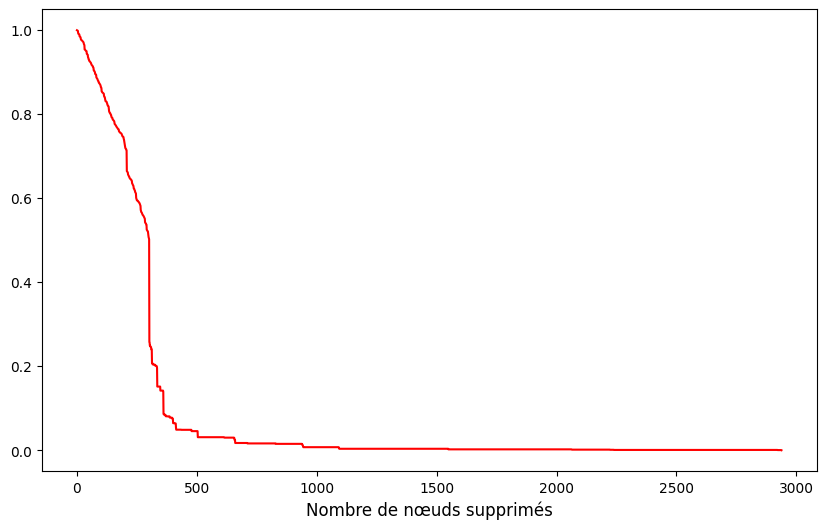

In [67]:
def simulate_targeted_failures(graph):
    original_size = len(max(nx.connected_components(graph), key=len))  # Taille initiale de la composante géante
    nodes_by_degree = sorted(graph.degree, key=lambda x: x[1], reverse=True)  # Nœuds triés par degré décroissant
    g_copy = graph.copy()  # Copie du graphe pour effectuer la simulation
    targeted_results = []  # Stocke la taille relative après chaque suppression

    for node, _ in nodes_by_degree:
        g_copy.remove_node(node)  # Supprime le nœud avec le plus haut degré
        if len(g_copy) > 0:
            largest_cc_size = len(max(nx.connected_components(g_copy), key=len))  # Taille composante géante
        else:
            largest_cc_size = 0
        targeted_results.append(largest_cc_size / original_size)  # Taille relative normalisée

    return targeted_results

# Simulation de pannes ciblées
targeted_failure_results = simulate_targeted_failures(graph)

# Visualisation des résultats
plt.figure(figsize=(10, 6))
plt.plot(range(len(targeted_failure_results)), targeted_failure_results, label="Suppression ciblée (par degré)", color="red")
plt.xlabel("Nombre de nœuds supprimés", fontsize=12)
plt


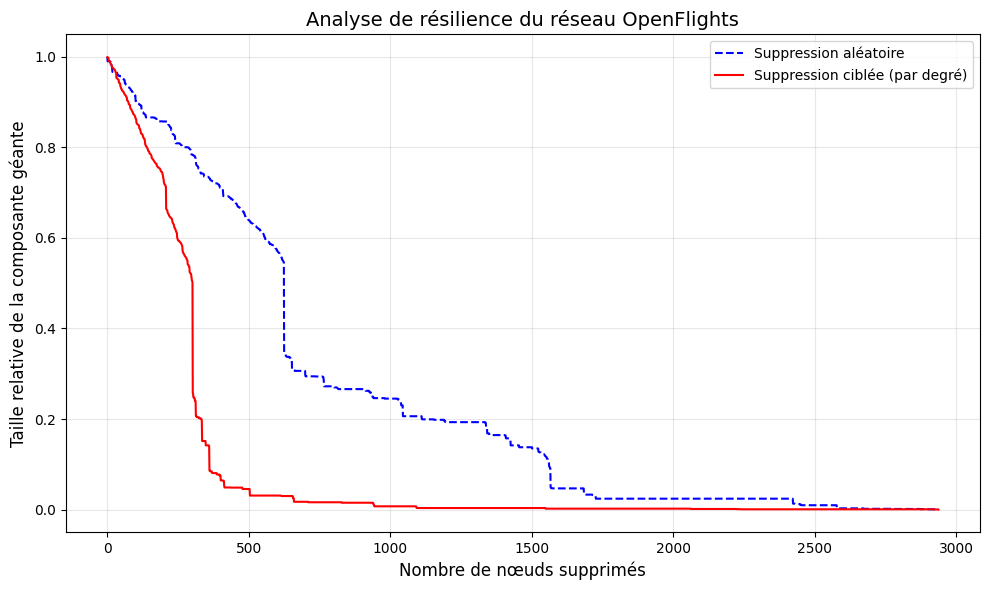

In [68]:
graph = nx.Graph()
graph.add_weighted_edges_from(cleaned_edges)


def simulate_resilience(graph):
    original_size = len(max(nx.connected_components(graph), key=len))  # Taille de la composante géante initiale
    nodes = list(graph.nodes)

    # Suppression aléatoire
    random_resilience = []
    g_random = graph.copy()
    for i, node in enumerate(nodes):
        g_random.remove_node(node)
        if len(g_random) > 0:
            largest_cc_size = len(max(nx.connected_components(g_random), key=len))
        else:
            largest_cc_size = 0
        random_resilience.append(largest_cc_size / original_size)  # Normalisé

    # Suppression ciblée (par degré décroissant)
    nodes_by_degree = sorted(graph.degree, key=lambda x: x[1], reverse=True)  # Tri par degré
    targeted_resilience = []
    g_targeted = graph.copy()
    for node, _ in nodes_by_degree:
        g_targeted.remove_node(node)
        if len(g_targeted) > 0:
            largest_cc_size = len(max(nx.connected_components(g_targeted), key=len))
        else:
            largest_cc_size = 0
        targeted_resilience.append(largest_cc_size / original_size)  # Normalisé

    return random_resilience, targeted_resilience

# Simulation de résilience
random_resilience, targeted_resilience = simulate_resilience(graph)

# Génération du graphique
plt.figure(figsize=(10, 6))
plt.plot(range(len(random_resilience)), random_resilience, label="Suppression aléatoire", color="blue", linestyle="--")
plt.plot(range(len(targeted_resilience)), targeted_resilience, label="Suppression ciblée (par degré)", color="red", linestyle="-")
plt.xlabel("Nombre de nœuds supprimés", fontsize=12)
plt.ylabel("Taille relative de la composante géante", fontsize=12)
plt.title("Analyse de résilience du réseau OpenFlights", fontsize=14)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()

# Sauvegarder l'image
plt.savefig("resilience_analysis.png")
plt.show()


## Visualisation
<a id="Visualisation"></a>

La visualisation d’un réseau est une étape clé pour explorer ses structures, ses communautés et ses hubs. Cette section présente une visualisation globale du réseau OpenFlights, permettant d’analyser ses caractéristiques visuelles et ses connexions majeures.

---

### Graphe global
<a id="Graphe-global"></a>

La visualisation globale du graphe permet de :
1. Identifier les principaux hubs du réseau, souvent représentés par des nœuds plus grands et plus connectés.
2. Observer les connexions principales et les clusters régionaux.
3. Mieux comprendre la structure hiérarchique et modulaire du réseau.

---

#### Méthodologie
1. Représenter les nœuds avec des tailles proportionnelles à leur degré.
2. Utiliser une disposition adaptée, comme le layout Spring, pour une meilleure visualisation.
3. Ajouter des couleurs pour distinguer les communautés ou les clusters.



/var/folders/rr/hj2x23vn64g9m265fnm93yd40000gn/T/ipykernel_53197/1616187318.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', len(communities))


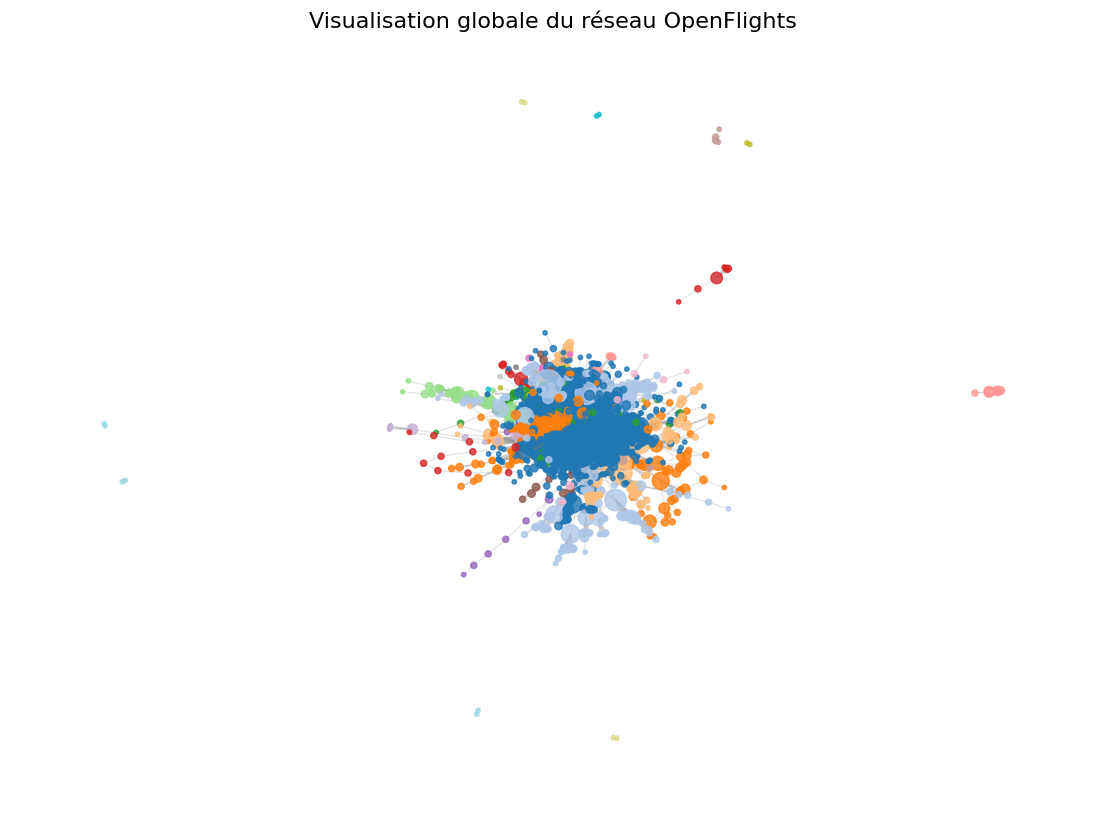

In [69]:
from matplotlib import cm
import matplotlib.colors as mcolors

# Calculer les degrés des nœuds pour ajuster leur taille
node_sizes = [graph.degree[node] * 10 for node in graph.nodes()]

# Détecter les communautés pour la coloration
from networkx.algorithms import community
communities = list(community.greedy_modularity_communities(graph))
cmap = cm.get_cmap('tab20', len(communities))
community_colors = {node: mcolors.to_hex(cmap(i)) for i, comm in enumerate(communities) for node in comm}

# Calculer les positions des nœuds avec un layout Spring
pos = nx.spring_layout(graph, seed=42)

# Tracer le graphe
plt.figure(figsize=(14, 10))
nx.draw_networkx_edges(graph, pos, alpha=0.2, edge_color="gray")
nx.draw_networkx_nodes(
    graph,
    pos,
    node_color=[community_colors[node] for node in graph.nodes()],
    node_size=node_sizes,
    alpha=0.8
)
plt.title("Visualisation globale du réseau OpenFlights", fontsize=16)
plt.axis("off")
plt.show()

### Sous-parties clés
<a id="Sous-parties-clés"></a>

Pour mieux comprendre les zones critiques ou intéressantes du réseau, cette section explore des sous-parties spécifiques du graphe. Ces sous-parties peuvent correspondre à :
1. Des hubs majeurs et leurs connexions locales.
2. Des clusters régionaux fortement connectés.
3. Des zones isolées ou peu connectées.

L’objectif est d’examiner ces sous-structures en détail pour analyser leur rôle et leur connectivité dans le réseau global.

---

#### Méthodologie
1. **Extraction des sous-parties :**
   - Identifier des groupes de nœuds ou des sous-graphes basés sur leur centralité, leur appartenance à une communauté, ou leur degré.
2. **Visualisation localisée :**
   - Tracer les sous-parties en isolant uniquement les nœuds et arêtes pertinents.

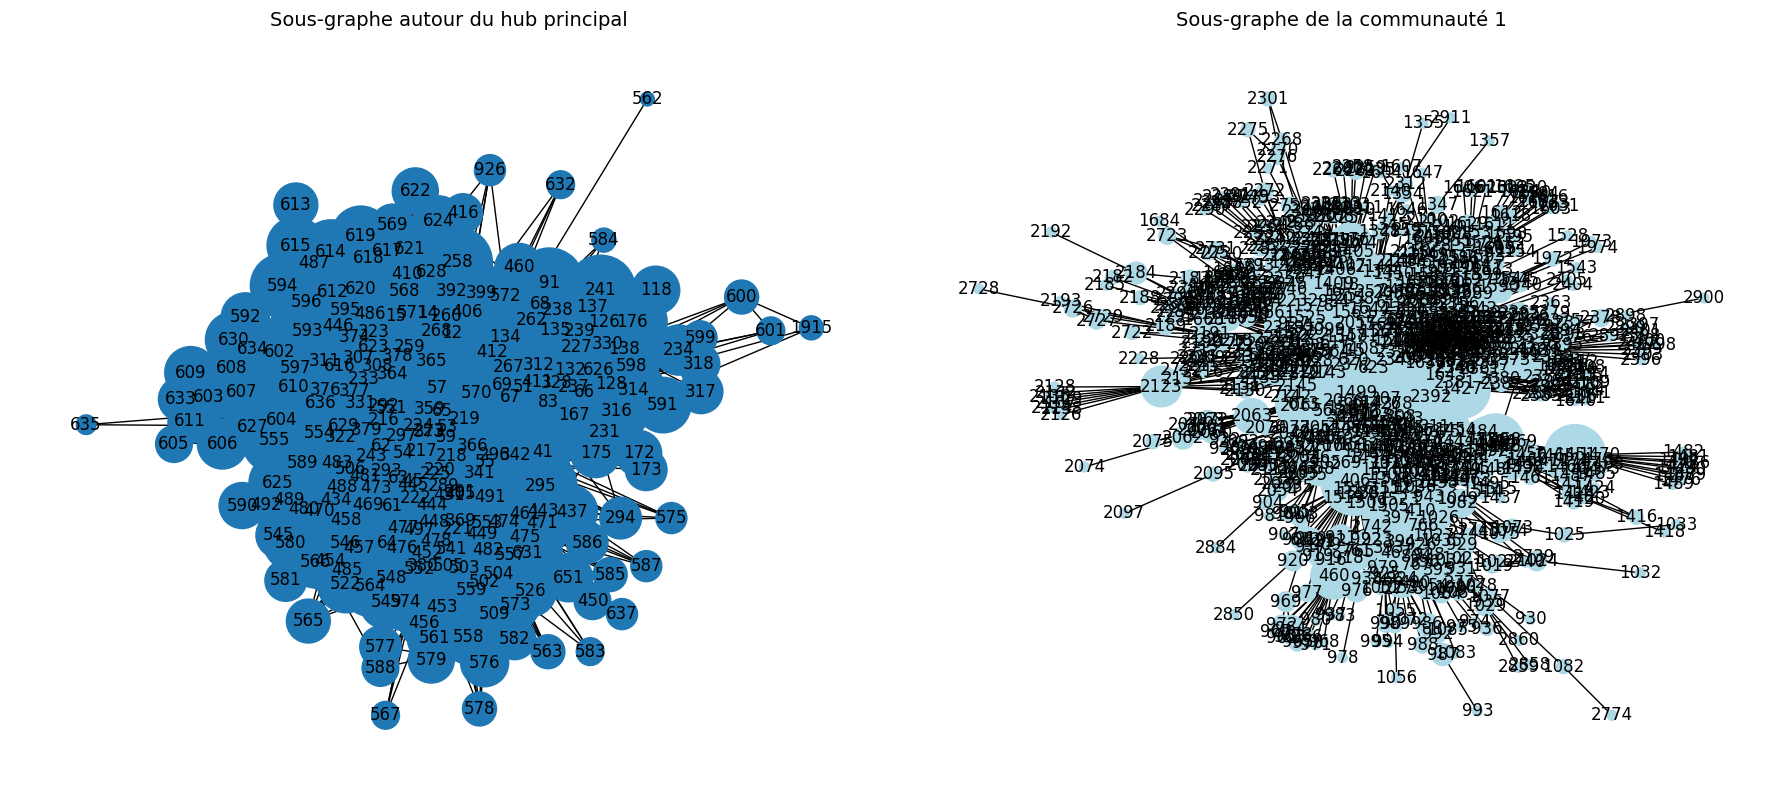

In [70]:

# Exemple 1 : Sous-graphe autour du hub principal (nœud avec le degré maximum)
hub_node = max(graph.degree, key=lambda x: x[1])[0]  # Trouver le hub principal
hub_neighbors = list(graph.neighbors(hub_node))  # Trouver ses voisins
subgraph_hub = graph.subgraph([hub_node] + hub_neighbors)  # Sous-graphe avec le hub et ses voisins

# Exemple 2 : Sous-graphe d'une communauté spécifique
community_index = 0  # Index de la communauté à visualiser
community_nodes = list(communities[community_index])  # Nœuds de la communauté
subgraph_community = graph.subgraph(community_nodes)  # Créer le sous-graphe

# Visualisation des sous-parties
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Visualisation du hub principal et de ses connexions
pos_hub = nx.spring_layout(subgraph_hub, seed=42)
nx.draw(
    subgraph_hub,
    pos=pos_hub,
    with_labels=True,
    node_size=[subgraph_hub.degree[node] * 100 for node in subgraph_hub.nodes],
    ax=axes[0]
)
axes[0].set_title("Sous-graphe autour du hub principal", fontsize=14)

# Visualisation de la communauté spécifique
pos_community = nx.spring_layout(subgraph_community, seed=42)
nx.draw(
    subgraph_community,
    pos=pos_community,
    with_labels=True,
    node_color="lightblue",
    node_size=[subgraph_community.degree[node] * 50 for node in subgraph_community.nodes],
    ax=axes[1]
)
axes[1].set_title(f"Sous-graphe de la communauté {community_index + 1}", fontsize=14)

plt.tight_layout()
plt.show()

## Conclusion
<a id="Conclusion"></a>

L’analyse du réseau OpenFlights a permis de mettre en lumière plusieurs aspects essentiels de sa structure et de son fonctionnement. Les résultats obtenus mettent en évidence une organisation hiérarchique, modulaire, et vulnérable aux pannes ciblées. 

---

### Résumé des observations clés

1. **Propriétés globales :**
   - Le réseau est clairsemé, avec une densité de connexions faible mais une composante géante qui regroupe la majorité des nœuds.
   - La structure hiérarchique est dominée par des hubs critiques assurant la connectivité globale.

2. **Centralité et communautés :**
   - Les mesures de centralité identifient des hubs stratégiques jouant un rôle clé dans l’interconnexion des clusters régionaux.
   - Les communautés détectées révèlent des regroupements géographiques ou fonctionnels avec une modularité élevée.

3. **Robustesse et résilience :**
   - Le réseau est robuste face à des pannes aléatoires grâce aux connexions redondantes dans les clusters.
   - Cependant, il est vulnérable aux pannes ciblées, où la suppression des hubs fragmentent rapidement la composante géante.

---

### Implications pratiques

1. **Optimisation des routes :**
   - Comprendre les hubs critiques peut aider à renforcer les connexions dans les régions isolées ou à planifier des routes alternatives pour améliorer la résilience.

2. **Planification stratégique :**
   - Les analyses de modularité et de clustering peuvent guider les décisions pour optimiser la gestion des flux aériens et les infrastructures.

---

### Perspectives

1. **Études supplémentaires :**
   - Simuler des scénarios spécifiques, comme l'impact de défaillances simultanées dans plusieurs régions.
   - Étudier l’évolution du réseau dans le temps pour analyser les tendances.

2. **Applications :**
   - Étendre cette analyse à d'autres types de réseaux, comme les réseaux routiers ou ferroviaires, pour des comparaisons intermodales.
   - Utiliser ces observations pour des stratégies d'intervention en cas de perturbations majeures.

---

Cette analyse démontre l’intérêt de la théorie des graphes et de la modélisation pour comprendre et optimiser des réseaux complexes comme celui d’OpenFlights.


# Bibliographie

Voici une liste des références utilisées dans ce document, incluant des ressources académiques et des outils logiciels :

- **OpenFlights Dataset**. Disponible à : [https://openflights.org/data.html](https://openflights.org/data.html)
- **NetworkX Documentation**. Disponible à : [https://networkx.org/documentation/stable/](https://networkx.org/documentation/stable/)
- **Gephi : Outil d'analyse de graphes**. Disponible à : [https://gephi.org/](https://gephi.org/)
- **Barabási, A.-L. (2016)**. *Network Science*. Cambridge University Press.
- **Newman, M. E. J. (2010)**. *Networks: An Introduction*. Oxford University Press.
- **Blondel, V. D., Guillaume, J.-L., Lambiotte, R., & Lefebvre, E. (2008)**. *Fast unfolding of communities in large networks*. *Journal of Statistical Mechanics: Theory and Experiment*, 2008(10), P10008.
- **Fortunato, S. (2010)**. *Community detection in graphs*. *Physics Reports*, 486(3-5), 75–174. DOI: [https://doi.org/10.1016/j.physrep.2009.11.002](https://doi.org/10.1016/j.physrep.2009.11.002)
- **Girvan, M., & Newman, M. E. J. (2002)**. *Community structure in social and biological networks*. *Proceedings of the National Academy of Sciences*, 99(12), 7821–7826. DOI: [https://doi.org/10.1073/pnas.122653799](https://doi.org/10.1073/pnas.122653799)
- **SciPy Documentation**. Disponible à : [https://scipy.org/docs.html](https://scipy.org/docs.html)
- **Matplotlib Documentation**. Disponible à : [https://matplotlib.org/stable/contents.html](https://matplotlib.org/stable/contents.html)
- **Python Software Foundation**. *Python Language Reference, version 3.9*. Disponible à : [https://docs.python.org/3.9/](https://docs.python.org/3.9/)


In [71]:
# Exporter le graphe au format GEXF pour Gephi
nx.write_gexf(graph, "openflights_network.gexf")
print("Le graphe a été exporté sous le nom 'openflights_network.gexf'")


Le graphe a été exporté sous le nom 'openflights_network.gexf'
